In [1]:
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import Audio
from keras.layers import Dense, LSTM, Input, Add
from keras.models import load_model
from keras.optimizers import Adam
from keras import Model

from Utilities.DataProcessors.TimeDomain import TimeDomain
from Utilities.Loss import WrightLoss

print('Imported')

2024-02-28 19:11:46.966414: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Imported


In [2]:
''' Pre process data '''
td = TimeDomain(sample_sec=0.5)
ip_shape, X_train = td.pre_process('X_train.wav')
ip_shape, Y_train = td.pre_process('Y_train.wav')
assert X_train.shape == Y_train.shape
print(ip_shape)

/Users/bunny/Files/Python/PyDistort/src/Utilities/DataProcessors/TimeDomain.py:37: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, wavfile = read(join(self.DATA_DIR, filepath))


(104, 22050, 1)


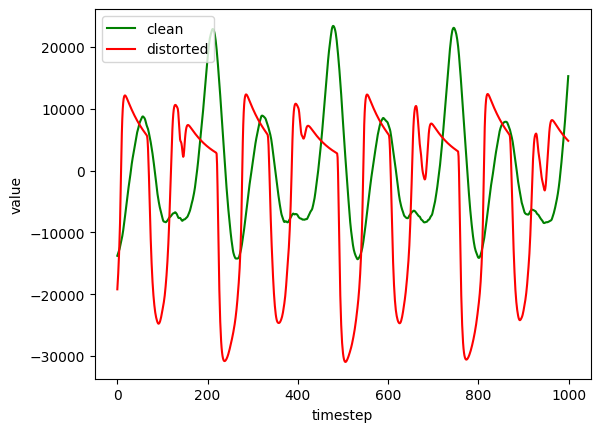

In [3]:
''' Plot X_train and Y_train ''' 

plt.plot(X_train[25][1000:2000], color='green')
plt.plot(Y_train[25][1000:2000], color='red')
plt.xlabel('timestep')
plt.ylabel('value')
plt.legend(['clean', 'distorted'], loc='upper left')
plt.show()

# Observation: Distorted signal closely follows clean closely
# but has high amplitude. Typical of Overdriven signal
# Also, Distorted seems to have lower troughs but marginally higher peaks, if any, when
# compared to clean signal
# Finally DC bias exists.

In [3]:
''' LSTM Model of the music data '''
# Since we are predicting a value for every timestep, we set return_sequences=True

input = Input(batch_shape=ip_shape)
mLSTM = LSTM(units=32, return_sequences=True)(input)
mLSTM = Dense(units=1, activation='linear')(mLSTM)

mDense = Dense(units=1, activation='linear')(input)
mSkip = Add()([mLSTM, mDense])

model = Model(input, mSkip)

adam = Adam(learning_rate=0.01)
wloss = WrightLoss(ratio=0.5)
model.compile(optimizer=adam, loss=wloss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(104, 22050, 1)]            0         []                            
                                                                                                  
 lstm (LSTM)                 (104, 22050, 32)             4352      ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (104, 22050, 1)              33        ['lstm[0][0]']                
                                                                                                  
 dense_1 (Dense)             (104, 22050, 1)              2         ['input_1[0][0]']             
                                                                                              

In [4]:
history = model.fit(X_train, Y_train, epochs=10, validation_split=0.3)

Epoch 1/10
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
3/3 [==============================] - 20s 6s/step - loss: 7785.9419 - val_loss: 2970.7737
Epoch 2/10
3/3 [==============================] - 18s 5s/step - loss: 7710.8057 - val_loss: 2965.9670
Epoch 3/10
3/3 [==============================] - 16s 5s/step - loss: 7603.9790 - val_loss: 2961.5208
Epoch 4/10
3/3 [==============================] - 17s 6s/step - loss: 6967.2363 - val_loss: 2957.2632
Epoch 5/10
3/3 [==============================] - 17s 6s/step - loss: 7149.4595 - val_loss: 2953.0967
Epoch 6/10
3/3 [==============================] - 16s 5s/step - loss: 7020.9585 - val_loss: 2948.8210
Epoch 7/10
3/3 [==============================] - 16s 6s/step - loss: 6629.8657 - val_loss: 2944.5901
Epoch 8/10
3/3 [==============================] - 17s 6s/step - loss: 6890.6753 - val_loss: 2940.7380
Epoch 9/10
3/3 [==============================] - 17s 6s/step - loss: 7022.9238 - val_loss: 2936.9885
Epoc

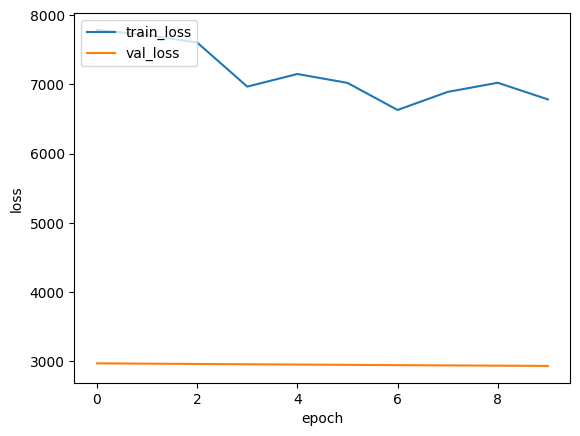

In [5]:
''' Plot train and val loss '''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [21]:
# Save model
model.save('Models/' + 'v1-lstm.keras')

TypeError: Cannot serialize object <Utilities.Loss.WrightLoss object at 0x14041eb10> of type <class 'Utilities.Loss.WrightLoss'>. To be serializable, a class must implement the `get_config()` method.

In [ ]:
# Load the model
model = load_model(join('Models', 'v1-lstm.keras'))

In [6]:
# Distort the test sample
_, X_test = td.pre_process('X_test.wav')
_, Y_test = td.pre_process('Y_test.wav')
Y_pred = model.predict(X_test)
print(Y_pred.shape)

2/2 [==============================] - 2s 707ms/step
(35, 22050, 1)


In [7]:
# saving the LSTM predicitons in wav format
wavfile = td.post_process(Y_pred)
td.save('Y_pred.wav', wavfile)

Saved!


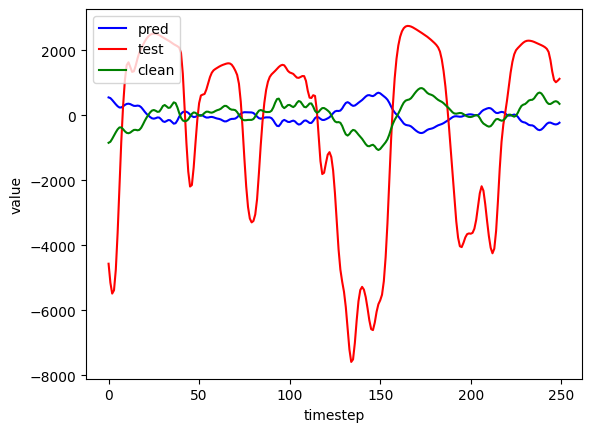

In [10]:
# Plot X_train and Y_train 
plt.plot(Y_pred[10][1000:1250], color='blue')
plt.plot(Y_test[10][1000:1250], color='red')
plt.plot(X_test[10][1000:1250], color='green')
plt.xlabel('timestep')
plt.ylabel('value')
plt.legend(['pred', 'test', 'clean'], loc='upper left')
plt.show()

In [9]:
# Play Predicted sample  
Audio( 'Data/Y_pred.wav', rate = 44100) 